In [1]:
import scanpy as sc

In [2]:
from bbtnn.tnn_v3 import *

In [3]:
%%capture
adata = sc.read("/Users/lsimon/Dropbox/Platelet/BBTNN/Merge_filter.h5")
sc.pp.recipe_zheng17(adata, n_top_genes = 3000)
sc.pp.neighbors(adata, n_neighbors = 20, n_pcs = 50)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


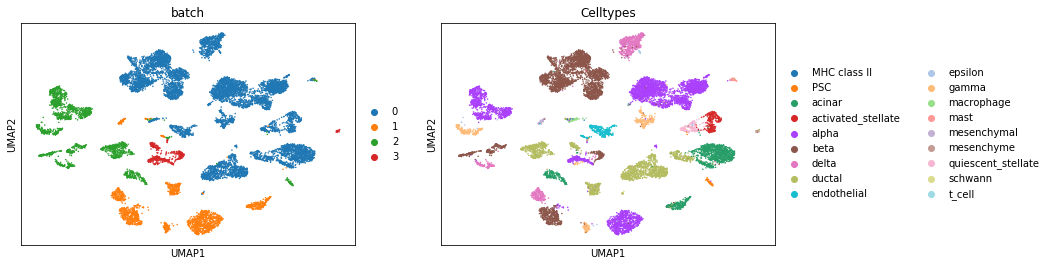

In [4]:
sc.pl.umap(adata, color = ["batch", "Celltypes"])

In [10]:
from bbtnn.tnn_v3 import *

In [11]:
%%time
model = TNN(k = 50, batch_size = 32, k_to_m_ratio = 1, n_epochs_without_progress = 5, verbose = 0)
model.fit(X = adata, batch_name = "batch", Y = None)
embedding = model.transform(X = adata)

Wall time: 3min 9s


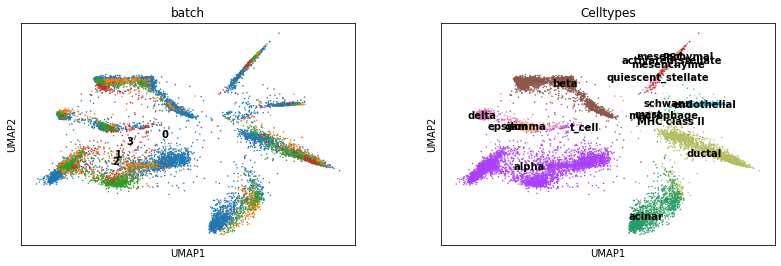

In [12]:
adata.obsm["X_umap"] = embedding
sc.pl.umap(adata, color = ["batch", "Celltypes"], legend_loc = "on data")

In [13]:
from bbtnn.tnn import *

In [ ]:
%%time
model = TNN(k = 50, batch_size = 32, n_epochs_without_progress = 5, verbose = 2)
model.fit(X = adata, Y = None)
embedding = model.transform(X = adata)

[[0.         0.2667295  0.15637764 0.02407002]
 [0.         0.         0.56361923 0.07658643]
 [0.         0.         0.         0.57549234]
 [0.         0.         0.         0.        ]]
7889
******Batches:[0, 1, 2, 3]
Categories (4, object): [0, 1, 2, 3]
******Total number of cells:13275
******Number of cells for MNN:5386
Training neural network
Epoch 1/1000
415/415 - 5s - loss: 0.8716
Epoch 2/1000
415/415 - 2s - loss: 0.4596
Epoch 3/1000
415/415 - 3s - loss: 0.3817
Epoch 4/1000
415/415 - 2s - loss: 0.3301
Epoch 5/1000
415/415 - 2s - loss: 0.2842
Epoch 6/1000


In [ ]:
adata.obsm["X_umap"] = embedding
sc.pl.umap(adata, color = ["batch", "Celltypes"], legend_loc = "on data")

### Add supervision to loss function

In [9]:
uniq = list(adata.obs["Celltypes"].unique())
y_labels = []
for i in adata.obs["Celltypes"]:
    y_labels.append(uniq.index(i))

In [10]:
%%time
model = TNN(k = 50, batch_size = 32, n_epochs_without_progress = 5, verbose = 2)
model.fit(X = adata, batch_name = "batch", Y = y_labels)
embedding = model.transform(X = adata)

Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (0, 3)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (2, 3)
5553 cells defined as MNNs
Calculating KNNs
4165 cells defined as KNNs
Re-format
Training neural network
Epoch 1/1000
304/304 - 4s - loss: 0.9090
Epoch 2/1000
304/304 - 3s - loss: 0.5198
Epoch 3/1000
304/304 - 3s - loss: 0.4454
Epoch 4/1000
304/304 - 3s - loss: 0.3749
Epoch 5/1000
304/304 - 3s - loss: 0.3527
Epoch 6/1000
304/304 - 3s - loss: 0.3268
Epoch 7/1000
304/304 - 3s - loss: 0.3154
Epoch 8/1000
304/304 - 3s - loss: 0.3042
Epoch 9/1000
304/304 - 3s - loss: 0.2950
Epoch 10/1000
304/304 - 3s - loss: 0.2794
Epoch 11/1000
304/304 - 3s - loss: 0.2800
Epoch 12/1000
304/304 - 3s - loss: 0.2653
Epoch 13/1000
304/304 - 3s - loss: 0.2555
Epoch 14/1000
304/304 - 3s - loss: 0.2578
Epoch 15/1000
304/304 - 3s - loss: 0.2628
Epoch 16/1000
304/304 - 3s - loss: 0.2453
Epoch 17/1000
304/304 - 3s - loss: 0.2431
Epoch 18

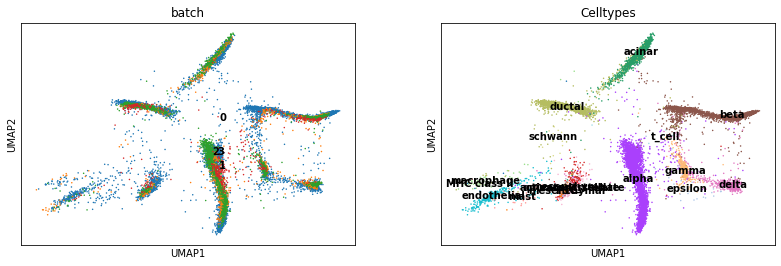

In [11]:
adata.obsm["X_umap"] = embedding
sc.pl.umap(adata, color = ["batch", "Celltypes"], legend_loc = "on data")

### Add semi-supervision to loss function

In [ ]:
mask = np.random.choice(range(len(Y_train)), size=len(Y_train) // 2, replace=False)
Y_train_masked = np.array(Y_train, dtype=np.int8) # Can't use uint to represent
Y_train_masked[mask] = -1